<a href="https://colab.research.google.com/github/June-user/GisHacaton/blob/main/Hacaton.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## AOI на Sentinel-2

In [1]:
import ee
import geemap
import ee.mapclient
import folium

project_id = 'ee-woovqw'

# Аутентификация и инициализация Earth Engine
ee.Authenticate()
ee.Initialize(project=project_id)

# 1. Область интереса
aoi = ee.Geometry.Point([63.0952911376953, 61.9183006286621])

# 2. Параметры визуализации
viz = {'min': 0, 'max': 0.3, 'bands': ['B4', 'B3', 'B2']}

# 3. Даты снимка
startDate1 = ee.Date.fromYMD(2023, 6, 1)
endDate1 = ee.Date.fromYMD(2023, 9, 30)

# Sentinel-2
# 4. Загрузка и фильтрация коллекции Sentinel-2
S2_1 = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED') \
    .filterDate(startDate1, endDate1) \
    .filterBounds(aoi) \
    .filterMetadata('CLOUDY_PIXEL_PERCENTAGE', 'less_than', 5) \
    .select(['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8'])

# 5. Создание медианного изображения, коррекция (10000) для Sentinel-2
img1 = ee.Image(S2_1.median()).divide(10000).set('period', '1');


# 6. Визуализация с помощью folium
# Карта ID и токен для визуализации
map_id_dict = img1.getMapId(viz)

# Создание карты folium
m = folium.Map(location=[61.9183006286621, 63.0952911376953], zoom_start=12)

# Слой с изображением на карте folium
folium.raster_layers.TileLayer(
    tiles=map_id_dict['tile_fetcher'].url_format,
    attr='Google Earth Engine',
    name='True Color 1'
).add_to(m)

# Контрол для вкл\выкл слоя
m.add_child(folium.LayerControl())

# Отображение
display(m)

KeyboardInterrupt: 

## AOI на LANDSAT

In [ ]:
import ee
import geemap
import ee.mapclient
import folium

project_id = 'ee-woovqw'

ee.Authenticate()
ee.Initialize(project=project_id)

aoi = ee.Geometry.Point([63.0054016113281, 61.940990447998])

viz = {'min': 0, 'max': 0.3, 'bands': ['SR_B4', 'SR_B3', 'SR_B2']}

startDate1 = ee.Date.fromYMD(2023, 6, 1)
endDate1 = ee.Date.fromYMD(2023, 9, 30)

# Landsat
L_9 = ee.ImageCollection('LANDSAT/LC09/C02/T1_L2') \
    .filterDate(startDate1, endDate1) \
    .filterBounds(aoi) \
    .select(['SR_B2', 'SR_B3', 'SR_B4'])
def apply_scale_factors(image):
  optical_bands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
  return image.addBands(optical_bands, None, True)
L_9 = L_9.map(apply_scale_factors)

imgL = ee.Image(L_9.median())


map_id_dict = imgL.getMapId(viz)

m = folium.Map(location=[61.940990447998, 63.0054016113281,], zoom_start=12)

folium.raster_layers.TileLayer(
    tiles=map_id_dict['tile_fetcher'].url_format,
    attr='Google Earth Engine',
    name='True Color 1'
).add_to(m)

m.add_child(folium.LayerControl())

display(m)

## Машинное обучение на Sentinel-2

In [ ]:

# Аутентификация в Google Earth Engine
import ee
import ee.mapclient
import geemap
import numpy as np
import pandas as pd
import geopandas as gpd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score

import folium


project_id = 'ee-woovqw'

# Аутентификация и инициализация Earth Engine
ee.Authenticate()
ee.Initialize(project=project_id)

# 1. Определение области интереса (AOI) и даты

start_date = '2023-05-01'
end_date = '2023-07-31'

# 2. Загрузка и подготовка обучающих данных (полигоны свалок из GeoPackage)

# Путь к GeoPackage (загрузите его в Colab или Google Drive)
gpkg_path = 'svalki_mine.gpkg'  # Замените на фактический путь
layer_name = 'svalki_mine'       # Замените на имя слоя с полигонами свалок в GeoPackage

gdf = gpd.read_file(gpkg_path, layer=layer_name)
print(gdf.head()) # Проверьте, что данные загрузились правильно


def geojson_to_ee_feature(feature):
    """Converts a GeoJSON Feature to an Earth Engine Feature and casts 'class' to int."""
    geom = feature['geometry']
    props = feature['properties']
    # Преобразуем 'class' в целое число
    try: # если class это int или float
        props['param'] = int(props['param'])
    except ValueError: # если class это строка
        try:
            props['param'] = int(float(props['param']))
        except ValueError:
            print(f"can't convert param label {props['param']} to integer")
            raise # кидаем оригинальную ошибку

    return ee.Feature(ee.Geometry(geom), props)

# Преобразование GeoDataFrame в GeoJSON
geojson_dat = gdf.__geo_interface__


# 1. Область интереса из geojson_path
geojson_path = 'polyg.geojson'
gdf = gpd.read_file(geojson_path)
geometry = gdf.geometry[0]

aoi = ee.Geometry(geometry.__geo_interface__)

# Создание списка ee.Feature из GeoJSON
ee_features = [geojson_to_ee_feature(f) for f in geojson_dat['features']]

# Создание FeatureCollection из списка ee.Feature
features = ee.FeatureCollection(ee_features)


# Пример использования Sentinel-2:
image_collection = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
                    .filterDate(start_date, end_date)
                    .filterBounds(aoi)
                    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20)))  # Фильтр по облачности

# Выбор нужных каналов (bands) - определите после фильтрации!
bands = ['B2', 'B3', 'B4', 'B8', 'B11', 'B12']

# Обработка изображений с разными наборами каналов (при необходимости)
def select_bands(image):
    return image.select(bands)

image_collection = image_collection.map(select_bands)

# Выбор медианного изображения (или другого подходящего способа композиции)
composite = image_collection.median()  # Теперь composite должен иметь только нужные bands
print(f"composite bands: {composite.bandNames().getInfo()}")  # Печать, чтобы убедиться в наборе каналов

# 4. Подготовка признаков (features) для машинного обучения
correct_class_name = 'param'

training = composite.sampleRegions(
    collection=features,
    properties=[correct_class_name],
    scale=10
)

# 5. Разделение данных на обучающую и тестовую выборки
training_data = training.randomColumn()
train_set = training_data.filter(ee.Filter.lt('random', 0.7))
test_set = training_data.filter(ee.Filter.gte('random', 0.7))

# 6. Обучение модели машинного обучения (Random Forest)
classifier = ee.Classifier.smileRandomForest(100)
classifier = classifier.train(
    features=train_set,
    classProperty=correct_class_name,
    inputProperties=bands
)

# 7. Оценка точности модели
test_accuracy = test_set.classify(classifier).errorMatrix(correct_class_name, correct_class_name)
print('Матрица ошибок теста: ', test_accuracy.getInfo())
print('Точность теста: ', test_accuracy.accuracy().getInfo())

# 8. Классификация изображения
classified_image = composite.classify(classifier)
classified_image = classified_image.clip(aoi)

# 9. Визуализация результатов
# Создание карты с помощью geemap
Map = geemap.Map()
Map.centerObject(aoi, 12)
Map.addLayer(composite, {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 3000}, 'Sentinel-2 Composite')
# Добавлено: min и max для визуализации
Map.addLayer(classified_image, {'min': 0, 'max': 1, 'palette': ['green', 'red']}, 'Landfill Classification')
Map.addLayer(features, {'color': 'yellow'}, 'Training Data') # Отображаем обучающие данные
Map  # Отображение карты в Colab

   param                                           geometry
0      1  POLYGON ((63.03157 61.91938, 63.03167 61.91936...
1      1  POLYGON ((63.0316 61.91921, 63.03172 61.91917,...
2      1  POLYGON ((63.00502 61.941, 63.00531 61.94106, ...
3      1  POLYGON ((62.99757 61.92777, 62.9979 61.92734,...
4      1  POLYGON ((63.007 61.91807, 63.00707 61.91791, ...
composite bands: ['B2', 'B3', 'B4', 'B8', 'B11', 'B12']
Матрица ошибок теста:  [[279, 0, 0, 0], [0, 116, 0, 0], [0, 0, 1057, 0], [0, 0, 0, 12]]
Точность теста:  1


Map(center=[61.92432311138493, 63.06703626906748], controls=(WidgetControl(options=['position', 'transparent_b…

## Намётки

In [ ]:
first_image = image_collection.first()
aoiimg = first_image.geometry()

In [ ]:

print(aoiimg.getInfo())
vectors = classified_image.reduceToVectors(
    geometry=aoiimg,
    scale=10,  # Разрешение пикселя
    crs='EPSG:4326', # Система координат
    geometryType='polygon',  # Тип геометрии (полигон)
    eightConnected=False,  # Использовать 4-связность (True для 8-связности)
    maxPixels=1e9
)


In [ ]:
export_params = {
    'collection': vectors,
    'description': 'landfill_polygons1',
    'folder': 'gee',
    'fileNamePrefix': 'landfill_polygons1',
    'fileFormat': 'GeoJSON',
}

task = ee.batch.Export.table.toDrive(**export_params)
task.start()

print('Задача экспорта векторов запущена. Проверьте Google Drive.')

In [ ]:
from google.colab import drive


export_params = {
    'image': classified_image,
    'region': aoiimg,  # Область интереса
    'maxPixels': 1e13, # Максимальное количество пикселей
    'description': 'landfill_classification3',  # Описание задачи
    'folder': 'gee',  # Папка на Google Drive (создайте ее заранее)
    'fileNamePrefix': 'landfill_classification3',  # Префикс имени файла
    'scale': 10,  # Разрешение пикселя (в метрах)
    'fileFormat': 'GeoTIFF',  # Формат файла
    'crs': 'EPSG:4326',  # Система координат (WGS 84)
}

# Запускаем задачу экспорта
task = ee.batch.Export.image.toDrive(**export_params)
task.start()

## Векторизация растра

In [ ]:
# 9. Векторизация результатов
landfill_mask = classified_image.eq(0)  # Бинарная маска для свалок

# Преобразование растра в векторные полигоны
aoi_polygon = aoi.buffer(1000).bounds()  # Создаем область вокруг точки (1 км буфер)
vectors = landfill_mask.reduceToVectors(
    geometry=aoi_polygon,
    scale=10,
    maxPixels=1e13,
    geometryType='polygon',
    eightConnected=False  # Используем 4-связность для более компактных полигонов
)

# 10. Экспорт в GeoJSON
output_file = 'landfills.geojson'
geemap.ee_export_vector(vectors, output_file, verbose=True)

print(f"Векторные полигоны сохранены в: {output_file}")

## Вектор в точки

In [ ]:

import geojson
from shapely.geometry import shape


def calculate_centroid(input_geojson, output_geojson):
    # Загрузка исходного файла
    with open(input_geojson, 'r') as f:
        data = geojson.load(f)

    features = []

    # Обработка каждой геометрии
    for feature in data.features:
        geom = shape(feature.geometry)

        # Для Polygon
        if geom.geom_type == 'Polygon':
            centroid = geom.centroid
            features.append(geojson.Feature(
                geometry=geojson.Point((centroid.x, centroid.y)),
                properties=feature.properties
            ))

        # Для MultiPolygon
        elif geom.geom_type == 'MultiPolygon':
            for polygon in geom.geoms:
                centroid = polygon.centroid
                features.append(geojson.Feature(
                    geometry=geojson.Point((centroid.x, centroid.y)),
                    properties=feature.properties
                ))

    # Сохранение результата
    with open(output_geojson, 'w') as f:
        geojson.dump(geojson.FeatureCollection(features), f)


# Пример использования
calculate_centroid('landfills.geojson', 'output.geojson')

## Машинное обучение на PlanetScope

In [ ]:
import ee
import glob
import os
import geemap
import geopandas as gpd
project_id = 'ee-woovqw'

# Аутентификация и инициализация Earth Engine
ee.Authenticate()
ee.Initialize(project=project_id)

def create_image_collection_from_assets(asset_ids):
  """Создает коллекцию из tif файлов PlanetScope"""
  images = []
  for asset_id in asset_ids:
      image = ee.Image(asset_id)
      images.append(image)
  return ee.ImageCollection.fromImages(images)


# Asset IDs из GEE
asset_ids = [
    'projects/ee-woovqw/assets/tif_scope/20240506_071757_28_247b_3B_AnalyticMS_SR_8b_clip',
    'projects/ee-woovqw/assets/tif_scope/20240520_061933_20_24a7_3B_AnalyticMS_SR_8b_clip',
    'projects/ee-woovqw/assets/tif_scope/20240520_061935_36_24a7_3B_AnalyticMS_SR_8b_clip',
    'projects/ee-woovqw/assets/tif_scope/20240530_063329_03_2456_3B_AnalyticMS_SR_8b_clip',
    'projects/ee-woovqw/assets/tif_scope/20240611_062817_43_2460_3B_AnalyticMS_SR_8b_clip',
    'projects/ee-woovqw/assets/tif_scope/20240611_062819_25_2460_3B_AnalyticMS_SR_8b_clip'
]

image_collection = create_image_collection_from_assets(asset_ids)

# 1. Область интереса из geojson_path
geojson_path = 'polyg.geojson'
gdf = gpd.read_file(geojson_path)
geometry = gdf.geometry[0]

aoi = ee.Geometry(geometry.__geo_interface__)


# Каналы
bands = ['b1', 'b2', 'b3', 'b4', 'b5', 'b6', 'b7', 'b8']

def select_bands(image):
    return image.select(bands)

# Коллекция по области aoi каналов
image_collection = image_collection.filterBounds(aoi).map(select_bands)

# Медианные растр
composite = image_collection.median()


# Преобразование разметочных данных из geojson
gpkg_path = 'svalki_mine.gpkg'  # Разметочные данные
layer_name = 'svalki_mine'       # Имя слоя

gdf = gpd.read_file(gpkg_path, layer=layer_name)
print(gdf.head()) # Проверка

def geojson_to_ee_feature(feature):
    """Преобразует объект GeoJSON в объект EEn, а веса - в int."""
    geom = feature['geometry']
    props = feature['properties']
    return ee.Feature(ee.Geometry(geom), props)

geojson_dat = gdf.__geo_interface__

ee_features = [geojson_to_ee_feature(f) for f in geojson_dat['features']]

features = ee.FeatureCollection(ee_features)


# Размеченные данные в выборки
correct_class_name = "param"

training = composite.sampleRegions(
    collection=features,
    properties=[correct_class_name],
    scale=10
)

training_data = training.randomColumn()
train_set = training_data.filter(ee.Filter.lt('random', 0.7))
test_set = training_data.filter(ee.Filter.gte('random', 0.7))


# 5. Машинное обучение
classifier = ee.Classifier.smileRandomForest(100)
classifier = classifier.train(
    features=train_set,
    classProperty=correct_class_name,
    inputProperties=bands
)

# 6. Точность модели
test_accuracy = test_set.classify(classifier).errorMatrix(correct_class_name, correct_class_name)
print('Матрица ошибок теста: ', test_accuracy.getInfo())
print('Точность теста: ', test_accuracy.accuracy().getInfo())

# 7. Классификация composite
classified_image_for_mask = composite.classify(classifier)




Map = geemap.Map()
Map.centerObject(aoi, 12)
Map.addLayer(composite, {'min': 0, 'max': 3000}, 'Composite')
Map.addLayer(classified_image_for_mask, {'min': 0, 'max': 1, 'palette': ['green', 'red']}, 'Landfill Classification')
Map.addLayer(features, {'color': 'yellow'}, 'Training Data') # Отображаем обучающие данные
Map  # Отображение карты в Colab


# file_name = 'classified_image_for_mask'  # Имя файла
# file_format = 'GeoTIFF'  # Формат файла
# folder = 'gee'  # Папка в Google Drive

# # Экспорт изображения
# task = ee.batch.Export.image.toDrive(
#     image=classified_image_for_mask,
#     description='Export Landfill Classification',
#     fileNamePrefix=file_name,
#     crs='EPSG:4326',
#     scale=10,
#     fileFormat=file_format,
#     folder=folder,
#     region=aoi
# )

# # Запуск задачи
# task.start()

   param                                           geometry
0      1  POLYGON ((63.03157 61.91938, 63.03167 61.91936...
1      1  POLYGON ((63.0316 61.91921, 63.03172 61.91917,...
2      1  POLYGON ((63.00502 61.941, 63.00531 61.94106, ...
3      1  POLYGON ((62.99757 61.92777, 62.9979 61.92734,...
4      1  POLYGON ((63.007 61.91807, 63.00707 61.91791, ...
Матрица ошибок теста:  [[320, 0, 0, 0], [0, 122, 0, 0], [0, 0, 1019, 0], [0, 0, 0, 12]]
Точность теста:  1


Map(center=[61.92432311138493, 63.06703626906748], controls=(WidgetControl(options=['position', 'transparent_b…

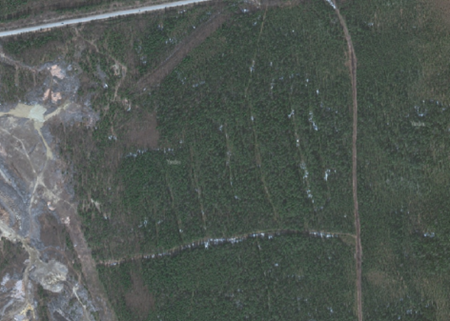

## Классификация на всех классах

In [ ]:
import ee
import glob
import os
import geemap
import geopandas as gpd
project_id = 'ee-woovqw'

# Аутентификация и инициализация Earth Engine
ee.Authenticate()
ee.Initialize(project=project_id)

def create_image_collection_from_assets(asset_ids):
  """Создает коллекцию из tif файлов PlanetScope"""
  if not asset_ids:
      print("Error: Asset ID list is empty.")
      return None
  images = []
  for asset_id in asset_ids:
      try:
          image = ee.Image(asset_id)
          images.append(image)
      except ee.ee_exception.EEException as e:
          print(f"Error: Could not load image from asset ID '{asset_id}'. {e}")
          return None  # Return None if any image fails to load

  return ee.ImageCollection.fromImages(images)


# Asset IDs из GEE
asset_ids = [
    'projects/ee-woovqw/assets/tif_scope/20240506_071757_28_247b_3B_AnalyticMS_SR_8b_clip',
    'projects/ee-woovqw/assets/tif_scope/20240520_061933_20_24a7_3B_AnalyticMS_SR_8b_clip',
    'projects/ee-woovqw/assets/tif_scope/20240520_061935_36_24a7_3B_AnalyticMS_SR_8b_clip',
    'projects/ee-woovqw/assets/tif_scope/20240530_063329_03_2456_3B_AnalyticMS_SR_8b_clip',
    'projects/ee-woovqw/assets/tif_scope/20240611_062817_43_2460_3B_AnalyticMS_SR_8b_clip',
    'projects/ee-woovqw/assets/tif_scope/20240611_062819_25_2460_3B_AnalyticMS_SR_8b_clip'
]

image_collection = create_image_collection_from_assets(asset_ids)

# 1. Область интереса из geojson_path
geojson_path = 'polyg.geojson'
gdf = gpd.read_file(geojson_path)
geometry = gdf.geometry[0]

aoi = ee.Geometry(geometry.__geo_interface__)


# Каналы
bands = ['b1', 'b2', 'b3', 'b4', 'b5', 'b6', 'b7', 'b8']

def select_bands(image):
    return image.select(bands)

# Коллекция по области aoi каналов
image_collection = image_collection.filterBounds(aoi).map(select_bands)

# Медианные растр
composite = image_collection.median()


# Преобразование разметочных данных из geojson
gpkg_path = 'svalki_mine.gpkg'  # Разметочные данные
layer_name = 'svalki_mine'       # Имя слоя

gdf = gpd.read_file(gpkg_path, layer=layer_name)
print(gdf.head()) # Проверка

def geojson_to_ee_feature(feature):
    """Преобразует объект GeoJSON в объект EEn, а веса - в int."""
    geom = feature['geometry']
    props = feature['properties']
    return ee.Feature(ee.Geometry(geom), props)

geojson_dat = gdf.__geo_interface__

ee_features = [geojson_to_ee_feature(f) for f in geojson_dat['features']]

features = ee.FeatureCollection(ee_features)


# Размеченные данные в выборки
correct_class_name = "param"

training = composite.sampleRegions(
    collection=features,
    properties=[correct_class_name],
    scale=10
)

training_data = training.randomColumn()
train_set = training_data.filter(ee.Filter.lt('random', 0.7))
test_set = training_data.filter(ee.Filter.gte('random', 0.7))


# 5. Машинное обучение
classifier = ee.Classifier.smileRandomForest(10)
classifier = classifier.train(
    features=train_set,
    classProperty=correct_class_name,
    inputProperties=bands
)

# 6. Точность модели
test_accuracy = test_set.classify(classifier).errorMatrix(correct_class_name, correct_class_name)
print('Матрица ошибок теста: ', test_accuracy.getInfo())
print('Точность теста: ', test_accuracy.accuracy().getInfo())

# 7. Классификация composite
classified_image = composite.classify(classifier)




Map = geemap.Map()
Map.centerObject(aoi, 12)
Map.addLayer(composite, {'min': 0, 'max': 3000}, 'Composite')
Map.addLayer(classified_image, {'min': 0, 'max': 1, 'palette': ['green', 'red', 'grey', 'brown']}, 'Landfill Classification')
Map.addLayer(features, {'color': 'yellow'}, 'Training Data') # Отображаем обучающие данные
Map  # Отображение карты в Colab

   param                                           geometry
0      1  POLYGON ((63.03157 61.91938, 63.03167 61.91936...
1      1  POLYGON ((63.0316 61.91921, 63.03172 61.91917,...
2      1  POLYGON ((63.00502 61.941, 63.00531 61.94106, ...
3      1  POLYGON ((62.99757 61.92777, 62.9979 61.92734,...
4      1  POLYGON ((63.007 61.91807, 63.00707 61.91791, ...
Матрица ошибок теста:  [[320, 0, 0, 0], [0, 122, 0, 0], [0, 0, 1019, 0], [0, 0, 0, 12]]
Точность теста:  1


Map(center=[61.92432311138493, 63.06703626906748], controls=(WidgetControl(options=['position', 'transparent_b…

## Классификация леса и города

In [ ]:

# Аутентификация в Google Earth Engine
import ee
import ee.mapclient
import geemap
import numpy as np
import pandas as pd
import geopandas as gpd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score

import folium


project_id = 'ee-woovqw'

# Аутентификация и инициализация Earth Engine
ee.Authenticate()
ee.Initialize(project=project_id)

# 1. Область интереса (AOI) и даты

start_date = '2023-05-01'
end_date = '2023-07-31'

# 2. Загрузка и подготовка обучающих данных (полигоны свалок из GeoPackage)

# Путь к GeoPackage
gpkg_path = 'les_ne_les.gpkg'
layer_name = 'les_ne_les'       # Имя слоя

gdf = gpd.read_file(gpkg_path, layer=layer_name)
print(gdf.head()) # Проверка


def geojson_to_ee_feature(feature):
    """Преобразует объект GeoJSON в объект EEn, а веса - в int. """
    geom = feature['geometry']
    props = feature['properties']
    # Преобразуем 'class' в целое число
    try: # если class это int или float
        props['param'] = int(props['param'])
    except ValueError: # если class это строка
        try:
            props['param'] = int(float(props['param']))
        except ValueError:
            print(f"can't convert param label {props['param']} to integer")
            raise # кидаем оригинальную ошибку

    return ee.Feature(ee.Geometry(geom), props)

# Преобразование GeoDataFrame в GeoJSON
geojson_dat = gdf.__geo_interface__

# Создание списка ee.Feature из GeoJSON
ee_features = [geojson_to_ee_feature(f) for f in geojson_dat['features']]

# Создание FeatureCollection из списка ee.Feature
features = ee.FeatureCollection(ee_features)


# Коллекция Sentinel-2:
image_collection = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
                    .filterDate(start_date, end_date)
                    .filterBounds(aoi)
                    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20)))  # Фильтр по облачности

# Выбор каналов
bands = ['B2', 'B3', 'B4', 'B8', 'B11', 'B12']

# Обработка изображений с разными наборами каналов
def select_bands(image):
    return image.select(bands)

image_collection = image_collection.map(select_bands)

# Выбор медианного изображения
composite = image_collection.median()  # Теперь composite должен иметь только нужные bands
print(f"composite bands: {composite.bandNames().getInfo()}")  # Проверка

# 4. Подготовка признаков для машинного обучения
correct_class_name = 'param'

training = composite.sampleRegions(
    collection=features,
    properties=[correct_class_name],
    scale=10
)

# 5. Разделение данных на обучающую и тестовую выборки
training_data = training.randomColumn()
train_set = training_data.filter(ee.Filter.lt('random', 0.7))
test_set = training_data.filter(ee.Filter.gte('random', 0.7))

# 6. Обучение модели машинного обучения (Random Forest)
classifier = ee.Classifier.smileRandomForest(100)
classifier = classifier.train(
    features=train_set,
    classProperty=correct_class_name,
    inputProperties=bands
)

# 7. Оценка точности модели
test_accuracy = test_set.classify(classifier).errorMatrix(correct_class_name, correct_class_name)
print('Матрица ошибок теста: ', test_accuracy.getInfo())
print('Точность теста: ', test_accuracy.accuracy().getInfo())

# 8. Классификация изображения
classified_image = composite.classify(classifier)
classified_image_mask = classified_image.clip(aoi)

# 9. Визуализация результатов
# Создание карты с помощью geemap
Map = geemap.Map()
Map.centerObject(aoi, 12)
Map.addLayer(composite, {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 3000}, 'Sentinel-2 Composite')
# Добавлено: min и max для визуализации
Map.addLayer(classified_image_mask, {'min': 0, 'max': 1, 'palette': ['red', 'green']}, 'Landfill Classification')
Map.addLayer(features, {'color': 'yellow'}, 'Training Data') # Отображаем обучающие данные
Map  # Отображение карты в Colab


# file_name = 'classified_image_mask'  # Имя файла
# file_format = 'GeoTIFF'  # Формат файла
# folder = 'gee'  # Папка в Google Drive

# # Экспорт изображения
# task = ee.batch.Export.image.toDrive(
#     image=classified_image_mask,
#     description='Export Landfill Classification',
#     fileNamePrefix=file_name,
#     crs='EPSG:4326',
#     scale=30,
#     fileFormat=file_format,
#     folder=folder,
#     region=aoi
# )

# # Запуск задачи
# task.start()

   param                                           geometry
0      0  POLYGON ((63.00484 61.92813, 63.00601 61.92628...
1      0  POLYGON ((63.01045 61.92782, 63.0108 61.92704,...
2      0  POLYGON ((63.01341 61.92714, 63.0141 61.92639,...
3      0  POLYGON ((63.02101 61.93056, 63.02164 61.92985...
4      0  POLYGON ((63.01902 61.93103, 63.01929 61.93072...
composite bands: ['B2', 'B3', 'B4', 'B8', 'B11', 'B12']
Матрица ошибок теста:  [[494, 0], [0, 10718]]
Точность теста:  1


Map(center=[61.92432311138493, 63.06703626906748], controls=(WidgetControl(options=['position', 'transparent_b…

## Маскирование

In [ ]:

classified_image_mask_asset = 'projects/ee-woovqw/assets/tif_mask/classified_image_mask'
classified_image_for_mask_asset = 'projects/ee-woovqw/assets/tif_mask/classified_image_for_mask'

# Загрузка изображений из Assets
classified_image_mask = ee.Image(classified_image_mask_asset)
classified_image_for_mask = ee.Image(classified_image_for_mask_asset)


# Маска
mask = classified_image_mask.eq(0)  # Растр, где значения 0 становятся 1, а остальные - 0 (False).

# 2. Инвертирование маски
reversed_mask = mask.Not()

# 3. Применение маски
masked_image = classified_image_for_mask.updateMask(reversed_mask)  # Удаляет пиксели, где mask равен 0 (False).


geojson_path = '/content/verh.geojson'
obrez = gpd.read_file(geojson_path)
geometry = obrez.geometry[0]

obrez = gpd.read_file(geojson_path)

# Получение всех геометрий из GeoDataFrame
geometries = obrez.geometry

# Преобразование shapely geometries в список ee.Geometry
ee_geometries = [ee.Geometry(geom.__geo_interface__) for geom in geometries]

# Создание ee.FeatureCollection из списка ee.Geometry
features = [ee.Feature(geom) for geom in ee_geometries]  # Создаем Features
feature_collection = ee.FeatureCollection(features)  # Создаем FeatureCollection

# Обрезка растра по FeatureCollection
clipped_image = masked_image.clipToCollection(feature_collection)

import ee.mapclient
Map = geemap.Map()
Map.centerObject(aoi, 12)
Map.addLayer(classified_image_for_mask, {'min': 0, 'max': 1}, 'Original Image')
Map.addLayer(classified_image_mask, {'min': 0, 'max': 1}, 'Mask Image')
Map.addLayer(clipped_image, {'min': 0, 'max': 1}, 'Masked Image')
Map

# task = ee.batch.Export.image.toDrive(
#     image=clipped_image,
#     description='Export masked_image Classification',
#     fileNamePrefix=file_name,
#     crs='EPSG:4326',
#     scale=10,
#     fileFormat=file_format,
#     folder=folder,
# )

# # Запуск задачи
# task.start()

Map(center=[61.92432311138493, 63.06703626906748], controls=(WidgetControl(options=['position', 'transparent_b…

In [ ]:
# 9. Векторизация результатов (пикселей со значением 0)
landfill_mask = clipped_image.eq(0)  # Создаем бинарную маску для свалок
landfill_mask = landfill_mask.Not()
# Преобразование растра в векторные полигоны
aoi_polygon = aoi

vectors = landfill_mask.selfMask().reduceToVectors( # Убираем все значения кроме тех, где маска равна true
    geometry=aoi_polygon,
    scale=10,
    maxPixels=1e13,
    geometryType='polygon',
    eightConnected=False  # Используем 4-связность для более компактных полигонов
)

# 10. Экспорт в GeoJSON
output_file = 'landfills.geojson'
geemap.ee_export_vector(vectors, output_file, verbose=True)

print(f"Векторные полигоны сохранены в: {output_file}")

Generating URL ...
Please wait ...
Data downloaded to /content/landfills.geojson
Векторные полигоны сохранены в: landfills.geojson


In [ ]:
import geojson
from shapely.geometry import shape


def calculate_centroid(input_geojson, output_geojson):
    # Загрузка исходного файла
    with open(input_geojson, 'r') as f:
        data = geojson.load(f)

    features = []

    # Обработка каждой геометрии
    for feature in data.features:
        geom = shape(feature.geometry)

        # Для Polygon
        if geom.geom_type == 'Polygon':
            centroid = geom.centroid
            features.append(geojson.Feature(
                geometry=geojson.Point((centroid.x, centroid.y)),
                properties=feature.properties
            ))

        # Для MultiPolygon
        elif geom.geom_type == 'MultiPolygon':
            for polygon in geom.geoms:
                centroid = polygon.centroid
                features.append(geojson.Feature(
                    geometry=geojson.Point((centroid.x, centroid.y)),
                    properties=feature.properties
                ))

    # Сохранение результата
    with open(output_geojson, 'w') as f:
        geojson.dump(geojson.FeatureCollection(features), f)


# Пример использования
calculate_centroid('landfills.geojson', 'output.geojson')

## Координаты полигонов

In [ ]:
import json

def add_coordinates_to_geojson(geojson_file):
    """
    Добавляет поле 'coordinates_json' с массивом координат в каждый объект GeoJSON.

    Args:
        geojson_file (str): Путь к файлу GeoJSON.
    """

    with open(geojson_file, 'r', encoding='utf-8') as f:
        data = json.load(f)

    for feature in data['features']:
        geometry = feature['geometry']

        if geometry['type'] == 'Polygon':
            coordinates = geometry['coordinates']
        elif geometry['type'] == 'MultiPolygon':
            coordinates = geometry['coordinates']  # Список полигонов

        else:
            print(f"Предупреждение: Объект ID {feature['id']} имеет неподдерживаемый тип геометрии: {geometry['type']}")
            feature['properties']['coordinates_json'] = None
            continue

        # Преобразование координат в строку JSON
        coordinates_json = json.dumps(coordinates)  # Преобразуем список списков в строку JSON
        feature['properties']['coordinates_json'] = coordinates_json

    # Сохранение измененного GeoJSON
    with open(geojson_file, 'w', encoding='utf-8') as f:
        json.dump(data, f, indent=2, ensure_ascii=False)  # Сохраняем с отступами и не-ASCII символами

    print(f"Координаты добавлены в файл: {geojson_file}")


# Пример использования:
geojson_file = 'landfills.geojson'  # Замените на путь к вашему файлу GeoJSON
add_coordinates_to_geojson(geojson_file)

Координаты добавлены в файл: landfills.geojson


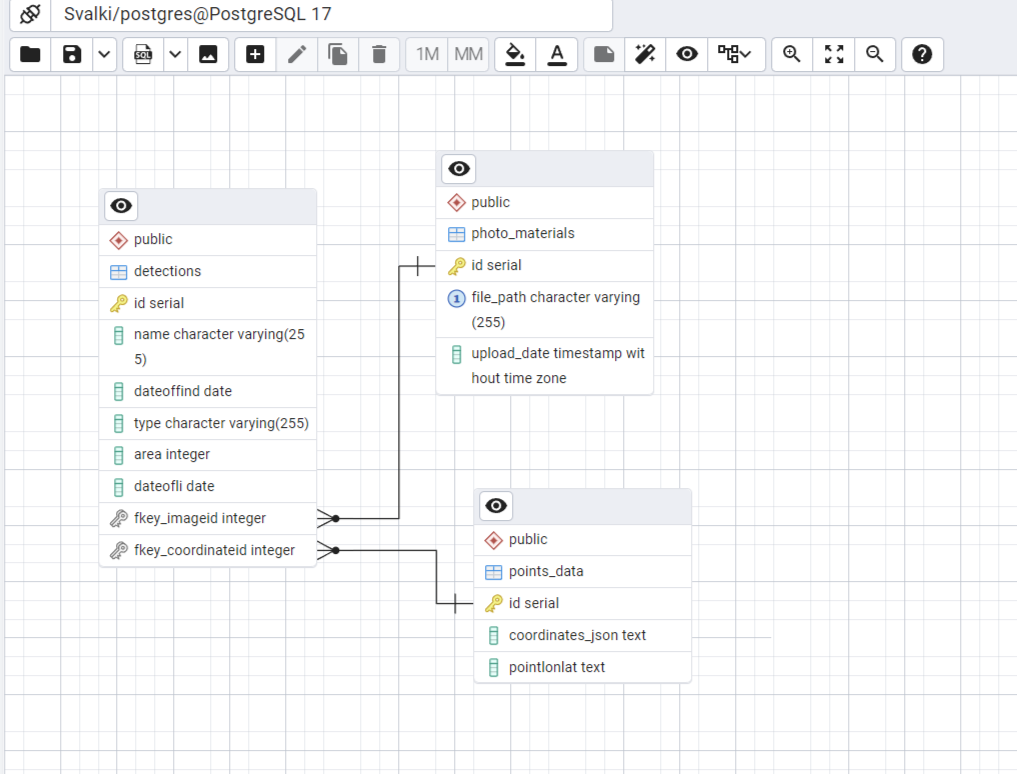